## Import Libraries

In [1]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM, Dense, Conv2D, TimeDistributed, Flatten, GRU, Dropout, MaxPooling2D, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

### Convert Raw video datasets into a 320x240 at 30fps

In [ ]:
def downgrade_video_quality(input_folder, output_folder, target_width=320, target_height=240, target_fps=30):
    """
    Downgrades the quality of videos in a given folder and organizes them by exercise name.

    Args:
        input_folder: The path to the folder containing the raw videos.
        output_folder: The path to the folder where the downgraded videos will be saved.
        target_width: The desired width of the output videos.
        target_height: The desired height of the output videos.
        target_fps:  The desired frames per second.  Crucially, get from the original.
    """

    # Create the output folder and subfolders if they don't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for exercise_name in os.listdir(input_folder):
        exercise_path = os.path.join(input_folder, exercise_name)

        # Check if it's a directory (to avoid processing non-directory files)
        if os.path.isdir(exercise_path):
            output_exercise_path = os.path.join(output_folder, exercise_name)
            if not os.path.exists(output_exercise_path):
                os.makedirs(output_exercise_path)

            for filename in os.listdir(exercise_path):
                if filename.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):  # Add more extensions if needed
                    input_filepath = os.path.join(exercise_path, filename)
                    output_filepath = os.path.join(output_exercise_path, filename)

                    try:
                        # Open the video file
                        video_capture = cv2.VideoCapture(input_filepath)

                        # Check if video opened successfully
                        if not video_capture.isOpened():
                            print(f"Error: Could not open video {input_filepath}")
                            continue

                        # Get original video properties
                        original_fps = video_capture.get(cv2.CAP_PROP_FPS)
                        # original_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)) #Not used
                        # original_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) #Not used
                        
                        # Use the original FPS if target_fps is not specified or is invalid
                        fps_to_use = original_fps if original_fps > 0 else target_fps

                        # Define the codec and create VideoWriter object
                        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI, or other codecs as needed
                        out = cv2.VideoWriter(output_filepath, fourcc, fps_to_use, (target_width, target_height))


                        while True:
                            ret, frame = video_capture.read()
                            if not ret:
                                break  # End of video

                            # Resize the frame
                            resized_frame = cv2.resize(frame, (target_width, target_height))

                            # Write the resized frame to the output video
                            out.write(resized_frame)

                        # Release resources
                        video_capture.release()
                        out.release()
                        print(f"Processed: {input_filepath} -> {output_filepath}")

                    except Exception as e:
                        print(f"Error processing {input_filepath}: {e}")

    print("Video processing complete.")



if __name__ == '__main__':
    raw_folder = "raw"  # Replace with the actual path to your raw videos folder
    downgraded_folder = "downgraded_raw"  # The output folder

    downgrade_video_quality(raw_folder, downgraded_folder)

### Set Numpy, Python, and TF seeds

In [6]:
model_input_size = (224,224,3)
seed_constant = 7
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

batch_size = 8 # Change this shit pag sasabog na yung GPU

## Visualize Data for 1st CNN stream


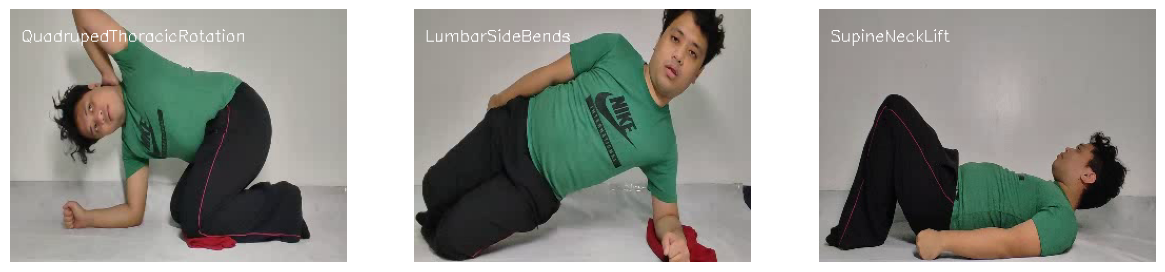

In [7]:
plt.figure(figsize = (20,20))

all_class_names = os.listdir('downgraded_raw')

random_range = random.sample(range(len(all_class_names)), 3)

for counter, random_index in enumerate(random_range, 1):
    selected_class_name = all_class_names[random_index]

    video_files_names_list = os.listdir(f'downgraded_raw/{selected_class_name}') 
    selected_video_file_name =  random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'downgraded_raw/{selected_class_name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()
    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255),1)

    plt.subplot(5,4, counter);plt.imshow(rgb_frame);plt.axis('off')


## PreProcess the Dataset

In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH =  64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = r"D:\MAPUA\CNN_GRU_usingRGBOF\downgraded_raw"

CLASSES_LIST = ['LumbarSideBends','QuadrupedThoracicRotation','SupineNeckLift']

## Extraction of Features 

1st Stream

In [9]:
def frames_extraction_RGB(video_path):
    #This function will be called after resizing and normalizing frames"

    frames_list1 = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
           break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame/255

        frames_list1.append(normalized_frame)
    
    video_reader.release()
    
    while len(frames_list1) < SEQUENCE_LENGTH:
        frames_list1.append(np.zeros_like(frames_list1[-1]))
    
    return frames_list1


2nd CNN Stream

###### Get optical flow frames

In [10]:
def compute_optical_flow(prev_frame, next_frame):
    # Convert frames to grayscale
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(21, 21), maxLevel=3, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    # Detect good features to track (Shi-Tomasi corners)
    feature_params = dict(maxCorners=3000, qualityLevel=0.01, minDistance=0.1)
    p0 = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)

    # Calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(prev_gray, next_gray, p0, None, **lk_params)

    # Select good points
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
    else:
        good_new, good_old = [], []

    return good_old, good_new

def create_mei_mhi(flow, shape, tau=10):
    # Initialize MEI and MHI
    mei = np.zeros(shape, dtype=np.float32)  # Binary motion energy
    mhi = np.zeros(shape, dtype=np.float32)  # Motion history with decay

    # Update MEI and MHI
    for (new, old) in zip(flow[1], flow[0]):
        x1, y1 = new.ravel()
        x2, y2 = old.ravel()
        
        # Draw motion on MEI (binary)
        cv2.line(mei, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)
        
        # Draw motion on MHI (with intensity based on time)
        cv2.line(mhi, (int(x1), int(y1)), (int(x2), int(y2)), 255, 2)

    # Update MHI with decay
    mhi[mhi > 0] -= 255 / tau  # Decay over time
    mhi[mhi < 0] = 0  # Ensure no negative values

    return mei, mhi

In [11]:
def frames_extraction_OF(video_path):
    # Initialize frames list to store MEI images
    frames_list2 = []

    # Open the video
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return frames_list2

    # Get total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterate through the video frames
    for frame_counter in range(0, video_frames_count - skip_frames_window, skip_frames_window):
        # Set the previous frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, prev_frame = video_reader.read()
        if not success:
            break

        # Set the next frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter + skip_frames_window)
        success, next_frame = video_reader.read()
        if not success:
            break

        # Resize frames to the desired dimensions
        prev_frame_resized = cv2.resize(prev_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        next_frame_resized = cv2.resize(next_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Compute optical flow between the previous and next frame
        good_old, good_new = compute_optical_flow(prev_frame_resized, next_frame_resized)

        # Check if optical flow computation was successful
        if len(good_old) == 0 or len(good_new) == 0:
            print(f"Warning: No optical flow vectors found for frames {frame_counter} and {frame_counter + skip_frames_window}.")
            continue

        # Create MEI (Motion Energy Image)
        mei, _ = create_mei_mhi((good_old, good_new), (IMAGE_HEIGHT, IMAGE_WIDTH), tau=10)

        # Normalize MEI for better visualization
        mei_norm = cv2.normalize(mei, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        # Append the MEI to the frames list
        frames_list2.append(mei_norm)

    # Release the video reader
    video_reader.release()

    while len(frames_list2) < SEQUENCE_LENGTH:
        frames_list2.append(np.zeros_like(frames_list2[-1]))

    return frames_list2


## Dataset Creation

1st Stream

In [12]:
def create_dataset_1st():
    #extracts the data of the selected class asnd create the required dataset
    features1 = []
    labels1 = []
    video_files_paths1 = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction_RGB(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features1.append(frames)
                labels1.append(class_index)
                video_files_paths1.append(video_file_path)
    
    features1 = np.asarray(features1)
    labels1 = np.array(labels1)

    return features1, labels1, video_files_paths1
            

In [13]:
#Create the dataset
features1, labels1, video_files_paths1 = create_dataset_1st()

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift


In [14]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels1 = to_categorical(labels1)

2nd Stream

In [15]:
def create_dataset_2nd():
    #extracts the data of the selected class asnd create the required dataset
    features2 = []
    labels2 = []
    video_files_paths2 = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction_OF(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:
                features2.append(frames)
                labels2.append(class_index)
                video_files_paths2.append(video_file_path)
    
    features2 = np.asarray(features2)
    labels2 = np.array(labels2)

    return features2, labels2, video_files_paths2
            

In [16]:
#Create the dataset
features2, labels2, video_files_paths2 = create_dataset_2nd()

Extracting Data of class: LumbarSideBends
Extracting Data of class: QuadrupedThoracicRotation
Extracting Data of class: SupineNeckLift


In [17]:
#convert labels into one-hot encoded vectors
one_hot_encoded_labels2 = to_categorical(labels2)

## Split Data into Train, Test, and Validation

For 1st Stream (RBG Data)

In [18]:
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, one_hot_encoded_labels1,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


For 2nd Stream (OF Data)

In [19]:
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, one_hot_encoded_labels2,
                                                                                test_size=0.20, shuffle = True, 
                                                                                random_state = seed_constant)


## Implement 2stream Model

In [20]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, GRU, Dense, Concatenate
from tensorflow.keras.models import Model

In [21]:
# Define input shapes
rgb_input_shape = (None, 224, 224, 3)  # (Time steps, Height, Width, Channels)
of_input_shape = (None, 224, 224, 2)   # (Time steps, Height, Width, OF Channels)
num_classes = 3 # Example: 10 action classes

Define the RGB CNN Architecture

In [ ]:
# Define the RGB CNN architecture
def create_rgb_cnn_architecture(input_shape=(224, 224, 3)):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)  # Flatten *after* TimeDistributed will flatten frame-wise features
    return Model(inputs=input_tensor, outputs=x)

Define the Optical Flow CNN architecture

In [ ]:
# Define the Optical Flow CNN architecture
def create_optical_flow_cnn_architecture(input_shape=(224, 224, 2)):
    input_tensor = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)  # Flatten *after* TimeDistributed will flatten frame-wise features
    return Model(inputs=input_tensor, outputs=x)

In [ ]:
def create_2stream_model():
    # Input layers
    input_rgb = Input(shape=rgb_input_shape)
    input_of = Input(shape=of_input_shape)

    # CNN models
    rgb_cnn_model = create_rgb_cnn_architecture()
    of_cnn_model = create_optical_flow_cnn_architecture()

    # TimeDistributed CNNs (Frame-wise feature extraction)
    rgb_features_sequence = TimeDistributed(rgb_cnn_model)(input_rgb)
    of_features_sequence = TimeDistributed(of_cnn_model)(input_of)

    # GRU layers
    rgb_gru_output = GRU(units=128)(rgb_features_sequence)  # Example GRU units
    of_gru_output = GRU(units=128)(of_features_sequence)    # Example GRU units

    # Fusion (Late Fusion - Concatenate)
    merged_features = Concatenate()([rgb_gru_output, of_gru_output])

    # Classification layers
    dense_layer = Dense(units=256, activation='relu')(merged_features)
    output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)

    # Create the 2-Stream Model
    model = Model(inputs=[input_rgb, input_of], outputs=output_layer)
    # Model Summary
    model.summary()
    
    return model

##### Display Architecture

In [ ]:
two_stream_model = create_2stream_model()

print("Model Created Successfully!")

In [ ]:
# Train the model
create_model = two_stream_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = create_model.fit(
    [features_train1, features_train2], labels_train1,
    validation_data=([features_test1, features_test2], labels_test1),
    epochs=10, batch_size=16
)

## Evaluate Model